<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/Main_MNIST_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffrax
!pip install equinox
!pip install einops
!pip install optax

In [ ]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

In [ ]:
def datashuffler(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

In [ ]:
class MixerBlock(eqx.Module):
    patch_mixer: eqx.nn.MLP
    hidden_mixer: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self, num_patches, hidden_size, mix_patch_size, mix_hidden_size, *, key
    ):
        tkey, ckey = jr.split(key, 2)
        self.patch_mixer = eqx.nn.MLP(
            num_patches, num_patches, mix_patch_size, depth=1, key=tkey
        )
        self.hidden_mixer = eqx.nn.MLP(
            hidden_size, hidden_size, mix_hidden_size, depth=1, key=ckey
        )
        self.norm1 = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.norm2 = eqx.nn.LayerNorm((num_patches, hidden_size))

    def __call__(self, y):
        y = y + jax.vmap(self.patch_mixer)(self.norm1(y))
        y = einops.rearrange(y, "c p -> p c")
        y = y + jax.vmap(self.hidden_mixer)(self.norm2(y))
        y = einops.rearrange(y, "p c -> c p")
        return y

In [ ]:
class Mixer2d(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.ConvTranspose2d
    blocks: list
    norm: eqx.nn.LayerNorm
    t1: float

    def __init__(
        self,
        img_size,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        *,
        key,
    ):
        input_size, height, width = img_size
        assert (height % patch_size) == 0
        assert (width % patch_size) == 0
        num_patches = (height // patch_size) * (width // patch_size)
        inkey, outkey, *bkeys = jr.split(key, 2 + num_blocks)

        self.conv_in = eqx.nn.Conv2d(
            input_size + 1, hidden_size, patch_size, stride=patch_size, key=inkey
        )
        self.conv_out = eqx.nn.ConvTranspose2d(
            hidden_size, input_size, patch_size, stride=patch_size, key=outkey
        )
        self.blocks = [
            MixerBlock(
                num_patches, hidden_size, mix_patch_size, mix_hidden_size, key=bkey
            )
            for bkey in bkeys
        ]
        self.norm = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.t1 = t1

    def __call__(self, t, y):
        t = t / self.t1
        _, height, width = y.shape
        t = einops.repeat(t, "-> 1 h w", h=height, w=width)
        y = jnp.concatenate([y, t])
        y = self.conv_in(y)
        _, patch_height, patch_width = y.shape
        y = einops.rearrange(y, "c h w -> c (h w)")
        for block in self.blocks:
            y = block(y)
        y = self.norm(y)
        y = einops.rearrange(y, "c (h w) -> c h w", h=patch_height, w=patch_width)
        return self.conv_out(y)

In [ ]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [ ]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [ ]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [ ]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

### MNIST Data

In [ ]:
def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)

In [ ]:
def main(
    # Model hyperparameters
    patch_size=4,
    hidden_size=64,
    mix_patch_size=512,
    mix_hidden_size=512,
    num_blocks=4,
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=1_000_000,
    lr=3e-4,
    batch_size=256,
    print_every=10_000,
    # Sampling hyperparameters
    dt0=0.1,
    sample_size=10,
    # Seed
    seed=2023,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, shuffle_key, sample_key = jr.split(key, 4)
    data = mnist()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = Mixer2d(
        data_shape,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        key=model_key,
    )
    int_beta = lambda t: t  # can change
    weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.

    opt = optax.adabelief(lr)
    # Optax will update the floating-point JAX arrays in the model.
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    total_value = 0
    total_size = 0
    for step, data in zip(range(num_steps), datashuffler(data, batch_size, key=shuffle_key)):
        value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
        total_value += value.item()
        total_size += 1
        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0

    sample_key = jr.split(sample_key, sample_size**2)
    sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
    sample = jax.vmap(sample_fn)(sample_key)
    sample = data_mean + data_std * sample
    sample = jnp.clip(sample, data_min, data_max)
    sample = einops.rearrange(sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size)
    plt.imshow(sample, cmap="Greys")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /content/data/mnist/train-images-idx3-ubyte.gz
Step=0 Loss=1.0156835317611694
Step=10000 Loss=0.02922505645379424
Step=20000 Loss=0.019791554643958806
Step=30000 Loss=0.01815911287115887
Step=40000 Loss=0.01723280158462003
Step=50000 Loss=0.016621904745977373
Step=60000 Loss=0.016186074649728835
Step=70000 Loss=0.015853265685774387
Step=80000 Loss=0.015570943235233427
Step=90000 Loss=0.015350976689253002
Step=100000 Loss=0.015160553277563304
Step=110000 Loss=0.014983382827602327
Step=120000 Loss=0.014844060292560607
Step=130000 Loss=0.014687800853699445
Step=140000 Loss=0.014567631778027862
Step=150000 Loss=0.014466329253744335
Step=160000 Loss=0.01435828631175682
Step=170000 Loss=0.014252856547106058
Step=180000 Loss=0.014179048114549368
Step=190000 Loss=0.014106179649289697
Step=200000 Loss=0.014042204735055566
Step=210000 Loss=0.013969292606320231
Step=220000 Loss=0.013914355365931988
Step=23

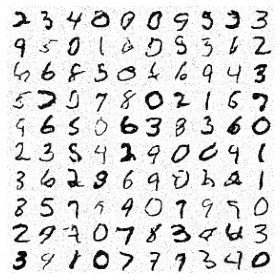

In [ ]:
main()

Save model

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
eqx.tree_serialise_leaves("MNIST_score.eqx", model)

In [ ]:
import shutil
shutil.copy('/content/MNIST_score.eqx','/content/gdrive/MyDrive/Colab Notebooks')

In [ ]:
"""Load model"""
# model_loaded = eqx.tree_deserialise_leaves("/content/gdrive/MyDrive/Colab Notebooks/MNIST_score.eqx", model)

### EMNIST data

In [ ]:
!pip install emnist

In [ ]:
from emnist import list_datasets

In [ ]:
# https://drive.google.com/uc?id=1R0blrtCsGEVLjVL3eijHMxrwahRUDK26
# ~/.cache/emnist/emnist.zip

In [ ]:
from emnist import extract_training_samples


def emnist():
  images, labels = extract_training_samples('balanced')
  qwep = einops.rearrange(images, "n h w -> n 1 h w")
  return jnp.array(qwep, dtype = jnp.uint8)

In [ ]:
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def main(
    # Model hyperparameters
    patch_size=4,
    hidden_size=64,
    mix_patch_size=512,
    mix_hidden_size=512,
    num_blocks=4,
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=1_000_000,
    lr=3e-4,
    batch_size=256,
    print_every=10_000,
    # Sampling hyperparameters
    dt0=0.1,
    sample_size=10,
    # Seed
    seed=2023,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, shuffle_key, sample_key = jr.split(key, 4)
    data = emnist()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = Mixer2d(
        data_shape,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        key=model_key,
    )
    int_beta = lambda t: t 
    weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.

    opt = optax.adabelief(lr)
    # Optax will update the floating-point JAX arrays in the model.
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    total_value = 0
    total_size = 0
    for step, data in zip(range(num_steps), datashuffler(data, batch_size, key=shuffle_key)):
        value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
        total_value += value.item()
        total_size += 1
        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0

    sample_key = jr.split(sample_key, sample_size**2)
    sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
    sample = jax.vmap(sample_fn)(sample_key)
    sample = data_mean + data_std * sample
    sample = jnp.clip(sample, data_min, data_max)
    sample = einops.rearrange(sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size)
    plt.imshow(sample, cmap="Greys")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    eqx.tree_serialise_leaves("emnist_model.eqx", model)
    shutil.copy('/content/emnist_model.eqx','/content/gdrive/MyDrive/Colab Notebooks')

Step=0 Loss=1.0156306028366089
Step=10000 Loss=0.029578453760780395
Step=20000 Loss=0.02052086243480444
Step=30000 Loss=0.01904210950601846
Step=40000 Loss=0.018201907648518683
Step=50000 Loss=0.017607065551914276
Step=60000 Loss=0.017183416890352965
Step=70000 Loss=0.016839435066469014
Step=80000 Loss=0.016556906227767468
Step=90000 Loss=0.01631780188092962
Step=100000 Loss=0.016134513247106224
Step=110000 Loss=0.01595854829698801
Step=120000 Loss=0.015825318631716073
Step=130000 Loss=0.01567530405735597
Step=140000 Loss=0.015563659939263017
Step=150000 Loss=0.015456489777751267
Step=160000 Loss=0.015356860932894052
Step=170000 Loss=0.015253593261353672
Step=180000 Loss=0.015177947358135133
Step=190000 Loss=0.015100407946668564
Step=200000 Loss=0.015034110186528414
Step=210000 Loss=0.014972931783553214
Step=220000 Loss=0.014916094894520938
Step=230000 Loss=0.014848040571156889
Step=240000 Loss=0.014793594410829246
Step=250000 Loss=0.014741410034988075
Step=260000 Loss=0.01467892451910

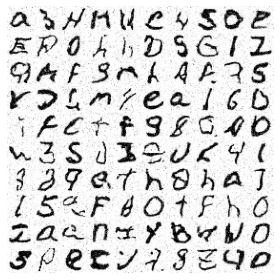

In [ ]:
main()